<a href="https://colab.research.google.com/github/Josepholaidepetro/mavencode_tfjob/blob/main/mavencode_tfjob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [2]:
# a quick neural network

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers.core import Dropout
import logging
import sys
import argparse
np.random.seed(1671)

Note: The following parameters below are key in the training of the network

In [4]:
# network and training 
NB_EPOCH = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10                              # class labels
OPTIMIZER = Adam()
N_HIDDEN = 128

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape  # prints Training data: (60000, 28, 28), (60000,) 
                                                          # prints Test data: (10000, 28, 28), (10000,)

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
class_labels = np.unique(y_train)
print("There are {} classes in the dataset. They are: {}".format(len(class_labels), class_labels))
# prints There are 10 classes in the dataset. They are: [0 1 2 3 4 5 6 7 8 9]

There are 10 classes in the dataset. They are: [0 1 2 3 4 5 6 7 8 9]


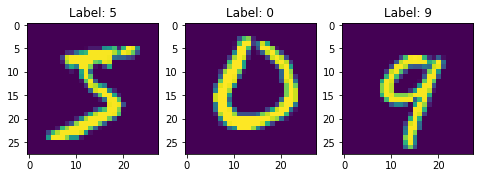

In [6]:
plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(X_train[0])
plt.title("Label: {}".format(y_train[0]))

plt.subplot(1,3,2)
plt.imshow(X_train[2500])
plt.title("Label: {}".format(y_train[2500]))

plt.subplot(1,3,3)
plt.imshow(X_test[12])
plt.title("Label: {}".format(y_test[12]))

plt.show()

In [7]:
RESHAPED = 28 * 28

In [8]:
X_train = X_train.reshape(60000,RESHAPED)
X_test = X_test.reshape(10000, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


As usual, we scale our dataset to range between 0 and 1. In this dataset, the pixel values range from 0 to 255.
Dividing the data by 255 scales to the required range

In [9]:
X_train /= 255     # rescaling
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [10]:
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)    # encode to_categorical variable
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)
print(Y_train.shape, 'train labels')
print(Y_test.shape, 'test labels')

(60000, 10) train labels
(10000, 10) test labels


In [23]:
def make_datasets(X_train, Y_train, X_test, Y_test, mode, batch_size=256):
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    num_epochs = None # indefinitely
    dataset = dataset.shuffle(buffer_size=10*batch_size)
  else:
    dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    num_epochs = 1 # end-of-input after this
 
  dataset = dataset.repeat(num_epochs).batch(batch_size)
  return dataset

def main(args):
  # Define a Keras Model.
  NB_CLASSES = 10 
  OPTIMIZER = Adam()
  N_HIDDEN = 128
  DROPOUT = 0.3
  RESHAPED = 784

  model = Sequential()
  model.add(Dense(N_HIDDEN,input_shape=(RESHAPED,)))
  model.add(Activation('relu'))
  model.add(Dropout(DROPOUT))
  model.add(Dense(N_HIDDEN))
  model.add(Activation('relu'))
  model.add(Dropout(DROPOUT))
  model.add(Dense(NB_CLASSES))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',optimizer=OPTIMIZER,
              metrics=['accuracy'])
  
  model.summary()
  tf.keras.backend.set_learning_phase(True)

  model_dir = args.saved_model_dir
  print('Using %s to store checkpoints.' % model_dir)

  # Define DistributionStrategies and convert the Keras Model to an
  # Estimator that utilizes these DistributionStrateges.
  # Evaluator is a single worker, so using MirroredStrategy.
  config = tf.estimator.RunConfig(
      experimental_distribute=tf.contrib.distribute.DistributeConfig(
          train_distribute=tf.contrib.distribute.CollectiveAllReduceStrategy(
              num_gpus_per_worker=0),
          eval_distribute=tf.contrib.distribute.MirroredStrategy(
              num_gpus_per_worker=0)))
  keras_estimator = tf.keras.estimator.model_to_estimator(
      keras_model=model, config=config, model_dir=model_dir)

  # Train and evaluate the model. Evaluation will be skipped if there is not an
  # "evaluator" job in the cluster.
  tf.estimator.train_and_evaluate(
      keras_estimator,
      train_spec=tf.estimator.TrainSpec(input_fn=make_datasets(X_train, Y_train, X_test, Y_test, mode=tf.estimator.ModeKeys.TRAIN, batch_size=256)),
      eval_spec=tf.estimator.EvalSpec(input_fn=make_datasets(X_train, Y_train, X_test, Y_test, mode=tf.estimator.ModeKeys.EVAL, batch_size=256)))


if __name__ == '__main__':
  logger = tf.get_logger()
  logger.setLevel(logging.INFO)
  parser = argparse.ArgumentParser()
  parser.add_argument('--saved_model_dir',
                      type=str,
                      required=True,
                      help='Tensorflow export directory.')

  parsed_args = parser.parse_args()
  tf.compat.v1.app.run(argv=sys.argv)
  main(parsed_args)

usage: ipykernel_launcher.py [-h] --saved_model_dir SAVED_MODEL_DIR
ipykernel_launcher.py: error: the following arguments are required: --saved_model_dir


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
